# Capstone 2 for Springboard - Walter Piper
# Modeling Notebook - Take 2

### From project proposal:
* Step 1: Establish physiological correlates of public speaking distress vs engagement. (ONLY STEP 1 IS ADDRESSED HERE)
#### Other steps not addressed.
* Step 2: Identify time-lagged predictors that can use physiological data to forecast distress versus engagement levels during a near-future public speaking task.
* Step 3: Identify any interactions between these predictors and the meditation sessions.
* Step 4: Develop a real-time forecasting algorithm that will recognize when meditation would be beneficial before Public Speaking.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
X_df = pd.read_csv('standardized_data.csv')
X_df = X_df.iloc[:, 1:]
print(X_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ACC_chest_energy_per_minute  75 non-null     float64
 1   ACC_wrist_energy_per_minute  75 non-null     float64
 2   Arousal                      75 non-null     float64
 3   EMG_energy_per_minute        75 non-null     float64
 4   GSR_rate                     75 non-null     float64
 5   HRV_RMSSD                    75 non-null     float64
 6   HR_avg                       75 non-null     float64
 7   Resp_autocorr_energy         75 non-null     float64
 8   Valence                      75 non-null     float64
 9   Age                          75 non-null     float64
 10  Height (cm)                  75 non-null     float64
 11  Weight (kg)                  75 non-null     float64
 12  Did you drink coffee today   75 non-null     float64
 13  Did you do any sports 

In [15]:
set(np.round(X_df.meditation_before_stress))

{-1.0, 1.0}

In [2]:
y_df = pd.read_csv('y_conditions.csv', usecols=[1])
print(y_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Condition  75 non-null     object
dtypes: object(1)
memory usage: 728.0+ bytes
None


# Step 1 - Identify physiological correlates of distress during social stress condition

### First, extract sympathetic nervous system activity as a whole with dimensionality reduction/decomposition of physio data.

(75, 7)


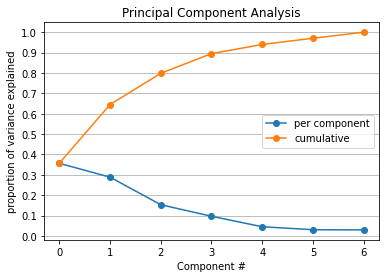

[[-0.10181837  0.26539548 -0.08265669 -0.17797623 -0.55464708 -0.54155927
  -0.52893362]
 [ 0.52025548 -0.47565593  0.6515533  -0.08548779 -0.03155014 -0.1790923
  -0.19541329]
 [-0.18983838 -0.23766816 -0.04802528  0.86816178  0.13693187 -0.20463082
  -0.30139644]
 [ 0.72470235  0.60275397 -0.09288541  0.31170386  0.06642778 -0.02364587
   0.02711787]
 [-0.07381844  0.12805982 -0.02709947 -0.27773229  0.79600504 -0.49294002
  -0.15384419]
 [ 0.29703997 -0.32236878 -0.55945801 -0.1816355   0.11375392  0.36409448
  -0.56245547]
 [ 0.25308741 -0.40397677 -0.49394776 -0.00504415 -0.14711986 -0.50660829
   0.50044329]]


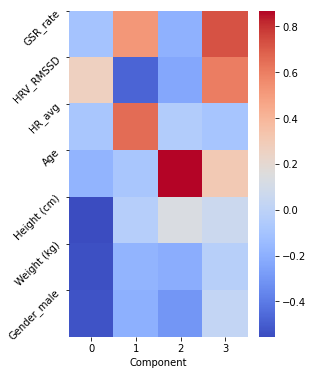

In [3]:
X_physio = X_df[['GSR_rate', 'HRV_RMSSD', 'HR_avg', 'Age', 'Height (cm)', 'Weight (kg)', 'Gender_male']]
print(X_physio.shape)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_physio)

def plot_PCA(pca_instance, n_components_for_heatmap=3):
    """Plots explained variance and feature contributions of components"""
    plt.plot(range(len(pca_instance.explained_variance_ratio_)), pca_instance.explained_variance_ratio_, marker='o', label='per component')
    plt.plot(range(len(pca_instance.explained_variance_ratio_)), np.cumsum(pca_instance.explained_variance_ratio_), marker='o', label='cumulative')
    plt.xlabel('Component #')
    plt.ylabel('proportion of variance explained')
    plt.legend(loc='center right')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(range(len(pca_instance.explained_variance_ratio_)))
    plt.grid(axis='y')
    plt.title('Principal Component Analysis')
    plt.show()
    
    print(pca_instance.components_)
    
    plt.figure(figsize=[4, 6])
    sns.heatmap(pca_instance.components_[:n_components_for_heatmap, :].T, cmap='coolwarm')
    plt.xlabel('Component')
    plt.yticks(range(7), labels=X_physio.columns, rotation=45)
    plt.show()

plot_PCA(pca, 4)

### Component 1 (2nd component) shows a positive association between electrodermal activity and heart rate, which are inverse of heart rate variability. This is a classic indicator of sympathetic nervous system activity over parasympathetic nervous system activity.

In [5]:
SNS_activity = pca.transform(X_physio)[:,1]

In [6]:
X_df['SNS_activity'] = SNS_activity

### Now we want to associate SNS_activity with self-reported Valence or self-reported Arousal. We want to do this for all conditions, then social stress alone vs all other conditions, and finally we want to see the breakdown for subjects meditating before social stress vs not meditating.

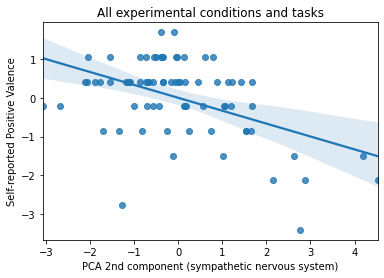

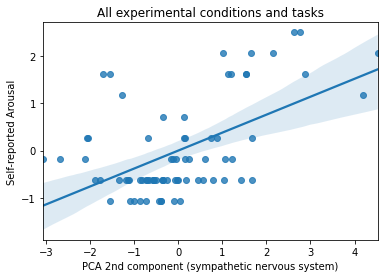

In [10]:
#mask = y_df.values.flatten() == 'SOCIAL STRESS'
sns.regplot(x=X_df['SNS_activity'], y=X_df['Valence'])
plt.xlabel('PCA 2nd component (sympathetic nervous system)')
plt.ylabel('Self-reported Positive Valence')
plt.title('All experimental conditions and tasks')
plt.show()

sns.regplot(x=X_df['SNS_activity'], y=X_df['Arousal'])
plt.xlabel('PCA 2nd component (sympathetic nervous system)')
plt.ylabel('Self-reported Arousal')
plt.title('All experimental conditions and tasks')
plt.show()

### At first, it appears that sympathetic nervous system activity is linked to bad emotional valence and high arousal. This is more or less consistent with general ideas about the autonomic nervous system

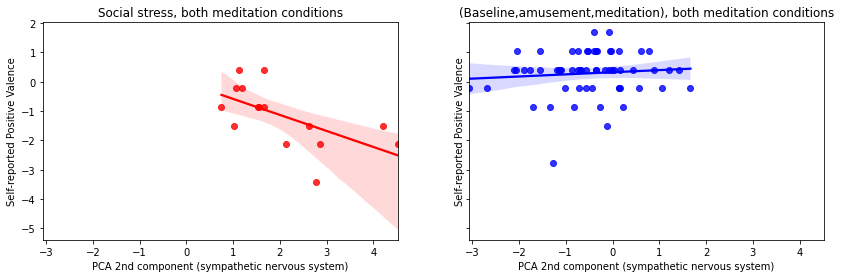

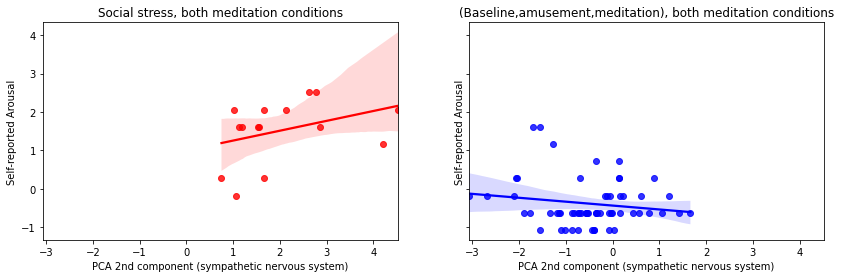

In [13]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True, figsize=[14,4])
stress_mask = y_df.values.flatten() == 'SOCIAL STRESS'
sns.regplot(x=X_df['SNS_activity'][stress_mask], y=X_df['Valence'][stress_mask], ax=ax[0], color='r')
ax[0].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[0].set_ylabel('Self-reported Positive Valence')
ax[0].set_title('Social stress, both meditation conditions')
sns.regplot(x=X_df['SNS_activity'][~stress_mask], y=X_df['Valence'][~stress_mask], ax=ax[1], color='b')
ax[1].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[1].set_ylabel('Self-reported Positive Valence')
ax[1].set_title('(Baseline,amusement,meditation), both meditation conditions')
plt.show()

fig, ax = plt.subplots(1,2,sharex=True,sharey=True, figsize=[14,4])
sns.regplot(x=X_df['SNS_activity'][stress_mask], y=X_df['Arousal'][stress_mask], ax=ax[0], color='r')
ax[0].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[0].set_ylabel('Self-reported Arousal')
ax[0].set_title('Social stress, both meditation conditions')
sns.regplot(x=X_df['SNS_activity'][~stress_mask], y=X_df['Arousal'][~stress_mask], ax=ax[1], color='b')
ax[1].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[1].set_ylabel('Self-reported Arousal')
ax[1].set_title('(Baseline,amusement,meditation), both meditation conditions')
plt.show()

### It seems like the previously observed associations were driven entirely by the social stress condition.

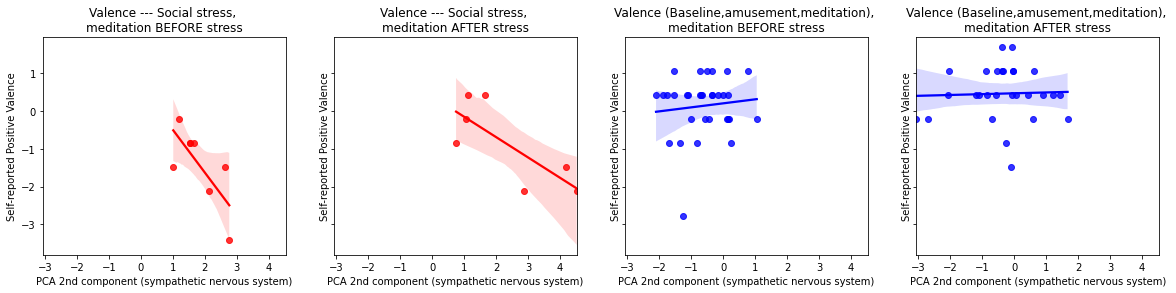

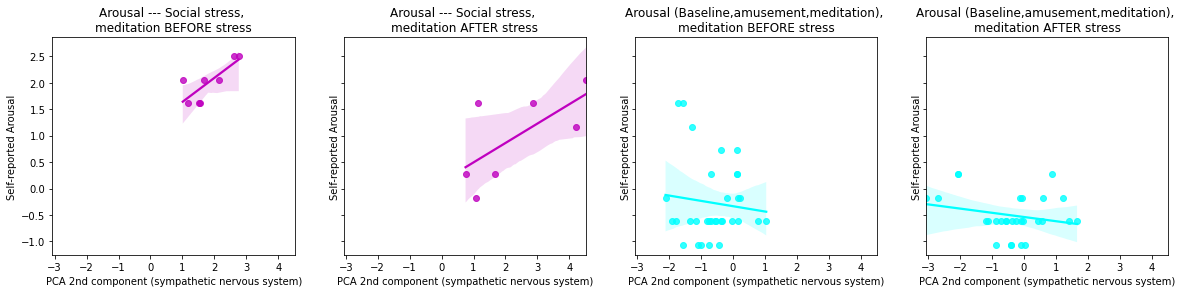

In [19]:
stress_mask = y_df.values.flatten() == 'SOCIAL STRESS'
meditation_before_stress_mask = np.round(X_df['meditation_before_stress'][stress_mask]) == 1
other_conditions_meditation_before_stress_mask = np.round(X_df['meditation_before_stress'][~stress_mask]) == 1

fig, ax = plt.subplots(1,4,sharex=True,sharey=True, figsize=[20,4])
sns.regplot(x=X_df['SNS_activity'][stress_mask][meditation_before_stress_mask],
            y=X_df['Valence'][stress_mask][meditation_before_stress_mask], ax=ax[0], color='r')
ax[0].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[0].set_ylabel('Self-reported Positive Valence')
ax[0].set_title('Valence --- Social stress, \nmeditation BEFORE stress')
sns.regplot(x=X_df['SNS_activity'][stress_mask][~meditation_before_stress_mask], 
            y=X_df['Valence'][stress_mask][~meditation_before_stress_mask], ax=ax[1], color='r')
ax[1].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[1].set_ylabel('Self-reported Positive Valence')
ax[1].set_title('Valence --- Social stress, \nmeditation AFTER stress')

sns.regplot(x=X_df['SNS_activity'][~stress_mask][other_conditions_meditation_before_stress_mask], 
            y=X_df['Valence'][~stress_mask][other_conditions_meditation_before_stress_mask], ax=ax[2], color='b')
ax[2].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[2].set_ylabel('Self-reported Positive Valence')
ax[2].set_title('Valence (Baseline,amusement,meditation), \nmeditation BEFORE stress')
sns.regplot(x=X_df['SNS_activity'][~stress_mask][~other_conditions_meditation_before_stress_mask], 
            y=X_df['Valence'][~stress_mask][~other_conditions_meditation_before_stress_mask], ax=ax[3], color='b')
ax[3].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[3].set_ylabel('Self-reported Positive Valence')
ax[3].set_title('Valence (Baseline,amusement,meditation), \nmeditation AFTER stress')
plt.show()

fig, ax = plt.subplots(1,4,sharex=True,sharey=True, figsize=[20,4])
sns.regplot(x=X_df['SNS_activity'][stress_mask][meditation_before_stress_mask],
            y=X_df['Arousal'][stress_mask][meditation_before_stress_mask], ax=ax[0], color='m')
ax[0].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[0].set_ylabel('Self-reported Arousal')
ax[0].set_title('Arousal --- Social stress, \nmeditation BEFORE stress')
sns.regplot(x=X_df['SNS_activity'][stress_mask][~meditation_before_stress_mask], 
            y=X_df['Arousal'][stress_mask][~meditation_before_stress_mask], ax=ax[1], color='m')
ax[1].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[1].set_ylabel('Self-reported Arousal')
ax[1].set_title('Arousal --- Social stress, \nmeditation AFTER stress')

sns.regplot(x=X_df['SNS_activity'][~stress_mask][other_conditions_meditation_before_stress_mask], 
            y=X_df['Arousal'][~stress_mask][other_conditions_meditation_before_stress_mask], ax=ax[2], color='cyan')
ax[2].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[2].set_ylabel('Self-reported Arousal')
ax[2].set_title('Arousal (Baseline,amusement,meditation), \nmeditation BEFORE stress')
sns.regplot(x=X_df['SNS_activity'][~stress_mask][~other_conditions_meditation_before_stress_mask], 
            y=X_df['Arousal'][~stress_mask][~other_conditions_meditation_before_stress_mask], ax=ax[3], color='cyan')
ax[3].set_xlabel('PCA 2nd component (sympathetic nervous system)')
ax[3].set_ylabel('Self-reported Arousal')
ax[3].set_title('Arousal (Baseline,amusement,meditation), \nmeditation AFTER stress')
plt.show()

### Meditation seems to have a more noticeable impact on the social stress segment (left plots) than the other segments (right plots).
### It seems that meditation is constraining the range of the sympathetic nervous system while boosting subjective arousal and having little or no effect on valence.
### I will now demonstrate that, during social stress, the physical and subjective states can predict the meditation condition.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 4 to 74
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SNS_activity              15 non-null     float64
 1   Valence                   15 non-null     float64
 2   Arousal                   15 non-null     float64
 3   meditation_before_stress  15 non-null     float64
dtypes: float64(4)
memory usage: 600.0 bytes
None


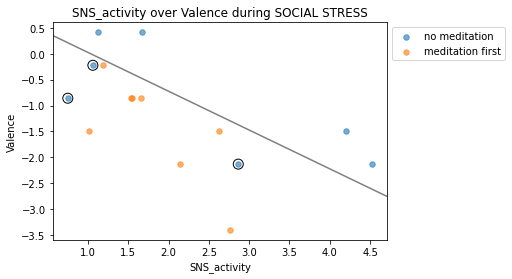

80.0  % accuracy when using ['SNS_activity', 'Valence']


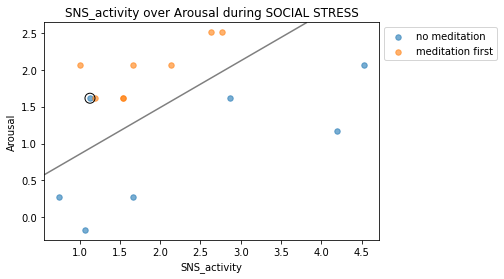

93.3  % accuracy when using ['SNS_activity', 'Arousal']


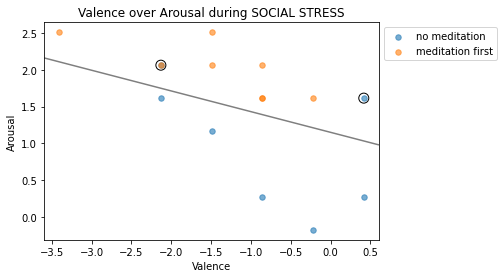

86.7  % accuracy when using ['Valence', 'Arousal']


In [27]:
# Modified from sklearn website's example for visualizing SVC


import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

temp_df = X_df[['SNS_activity','Valence','Arousal','meditation_before_stress']].loc[stress_mask]
temp_df['meditation_before_stress'] = np.round(temp_df.meditation_before_stress)
print(temp_df.info())
pair1 = ['SNS_activity','Valence']
pair2 = ['SNS_activity','Arousal']
pair3 = ['Valence','Arousal']

for pair in [pair1, pair2, pair3]:
    # fit the model, don't regularize for illustration purposes
    clf = svm.SVC(kernel='linear', C=1000)
    clf.fit(temp_df[pair], temp_df.meditation_before_stress)

    plt.scatter(temp_df[pair[0]][temp_df.meditation_before_stress == -1], 
                temp_df[pair[1]][temp_df.meditation_before_stress == -1], 
                s=30, cmap=plt.cm.Paired, label='no meditation', alpha=0.6)

    plt.scatter(temp_df[pair[0]][temp_df.meditation_before_stress == 1], 
                temp_df[pair[1]][temp_df.meditation_before_stress == 1], 
                s=30, cmap=plt.cm.Paired, label='meditation first', alpha=0.6)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    #ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
    #           linestyles=['--', '-', '--'])
    ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5)
    
    # circle misses
    truth_mask = np.sign(clf.decision_function(temp_df[pair])) == np.sign(temp_df['meditation_before_stress'])
    ax.scatter(temp_df.loc[:, pair[0]][~truth_mask], temp_df.loc[:, pair[1]][~truth_mask], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

    

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.title(pair[0]+' over '+pair[1]+' during SOCIAL STRESS')

    plt.show()
    #print(np.round(100*(1-len(clf.support_vectors_)/len(temp_df)),1),' % accuracy when using', pair)
    print(np.round(100*np.mean(truth_mask),1),' % accuracy when using', pair)

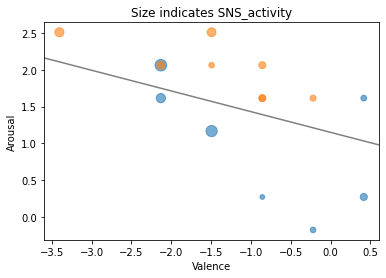

In [89]:
plt.scatter(temp_df['Valence'][temp_df.meditation_before_stress == -1], 
            temp_df['Arousal'][temp_df.meditation_before_stress == -1], 
            s=30*temp_df['SNS_activity'][temp_df.meditation_before_stress == -1], cmap=plt.cm.Paired, label='no meditation', alpha=0.6)

plt.scatter(temp_df['Valence'][temp_df.meditation_before_stress == 1], 
            temp_df['Arousal'][temp_df.meditation_before_stress == 1], 
            s=30*temp_df['SNS_activity'][temp_df.meditation_before_stress == 1], cmap=plt.cm.Paired, label='meditation first', alpha=0.6)
plt.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Size indicates SNS_activity')
plt.show()


### This is a little bit hard to interpret, but the effect of meditation is clarified . 
* Social stress induces increased subjective arousal, increased sympathetic nervous system arousal, and decreased positive valence.
* The starkest effect of meditation was on the interaction of subjective arousal and sympathetic nervous system arousal.
* It appears that meditation boosted subjective arousal while constraining the upper range of sympathetic nervous system arousal.

# If we make a leap and equate subjective arousal to engagement and low valence to distress, then our goal for step 1 is complete. 
## We have extracted a single composite measure (using PCA) of sympathetic nervous system (SNS) actvity.
## SNS activity during social stress is linked to increased engagement, but also to increased distress.
## Meditation enhances engagement and limits SNS activity. However, distress is not affected.
##### It must be noted, constraining SNS activity could preserve physical health, which in a sense, limits future distress in the form of health problems.

# Modeling with SVC

In [94]:
from sklearn.model_selection import GridSearchCV
params = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

svc_gs = GridSearchCV(svm.SVC(), params, scoring='f1_micro', cv=5, n_jobs=-1)
svc_gs.fit(temp_df[['Valence','Arousal','SNS_activity']], temp_df.meditation_before_stress)
print(svc_gs.best_params_)
print(svc_gs.best_score_)

{'C': 1}
0.8666666666666666


In [90]:
from sklearn.model_selection import train_test_split

print('Training a SVC on Valence, Arousal, and SNS_activity')
print('Randomly splitting 15 datapoints into 12 training points and 3 test points. Repeating 1000 times.')
acc_list=[]
acc_no_medi_list = []
acc_medi_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(temp_df[['Valence','Arousal','SNS_activity']], temp_df.meditation_before_stress,
                                                       test_size=0.2)
    
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    truth_mask = np.sign(clf.decision_function(X_test)) == np.sign(y_test)
    try:
        truth_mask2 = np.sign(clf.decision_function(X_test[y_test == -1])) == np.sign(y_test[y_test == -1])
        acc_no_medi_list.extend(truth_mask2)
    except:
        continue
    try:
        truth_mask3 = np.sign(clf.decision_function(X_test[y_test == 1])) == np.sign(y_test[y_test == 1])
        acc_medi_list.extend(truth_mask3)
    except:
        continue
    #print('fitting SVC on all 3 features, arousal, valence, and SNS activity')
    #print('accuracy =', 100*np.mean(truth_mask))
    acc_list.append(100*np.mean(truth_mask))
    
print('\n','Total accuracy =', np.mean(acc_list))
print('Subset accuracy for non-meditators =', 100*np.mean(acc_no_medi_list))
print('Subset accuracy for meditators =', 100*np.mean(acc_medi_list),'\n')

print('\n','This is not a fully valid test of this idea, as there are only 15 datapoints')

Training a SVC on Valence, Arousal, and SNS_activity
Randomly splitting 15 datapoints into 12 training points and 3 test points. Repeating 1000 times.

 Total accuracy = 83.14417822614543
Subset accuracy for non-meditators = 64.68506723283794
Subset accuracy for meditators = 99.25742574257426 


 This is not a fully valid test of this idea, as there are only 15 datapoints


# I also want to try logistic modeling

In [96]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [97]:
lr = LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100, 1000])
lr.fit(temp_df[['Valence','Arousal','SNS_activity']], temp_df.meditation_before_stress)
print(lr.C_)
print(lr.scores_)

[10.]
{1.0: array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667],
       [0.66666667, 0.66666667, 1.        , 1.        , 1.        ,
        1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.66666667, 0.66666667,
        0.66666667],
       [0.33333333, 0.33333333, 1.        , 1.        , 1.        ,
        1.        ]])}


In [98]:
from sklearn.model_selection import train_test_split

print('Training a LogisticRegression on Valence, Arousal, and SNS_activity')
print('Randomly splitting 15 datapoints into 12 training points and 3 test points. Repeating 1000 times.')
acc_list=[]
acc_no_medi_list = []
acc_medi_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(temp_df[['Valence','Arousal','SNS_activity']], temp_df.meditation_before_stress,
                                                       test_size=0.2)
    
    clf = LogisticRegression(C=10)
    clf.fit(X_train, y_train)
    truth_mask = np.sign(clf.decision_function(X_test)) == np.sign(y_test)
    try:
        truth_mask2 = np.sign(clf.decision_function(X_test[y_test == -1])) == np.sign(y_test[y_test == -1])
        acc_no_medi_list.extend(truth_mask2)
    except:
        continue
    try:
        truth_mask3 = np.sign(clf.decision_function(X_test[y_test == 1])) == np.sign(y_test[y_test == 1])
        acc_medi_list.extend(truth_mask3)
    except:
        continue
    #print('fitting SVC on all 3 features, arousal, valence, and SNS activity')
    #print('accuracy =', 100*np.mean(truth_mask))
    acc_list.append(100*np.mean(truth_mask))
    
print('\n','Total accuracy =', np.mean(acc_list))
print('Subset accuracy for non-meditators =', 100*np.mean(acc_no_medi_list))
print('Subset accuracy for meditators =', 100*np.mean(acc_medi_list),'\n')

print('\n','This is not a fully valid test of this idea, as there are only 15 datapoints')

Training a LogisticRegression on Valence, Arousal, and SNS_activity
Randomly splitting 15 datapoints into 12 training points and 3 test points. Repeating 1000 times.

 Total accuracy = 84.2940685045948
Subset accuracy for non-meditators = 65.87982832618026
Subset accuracy for meditators = 100.0 


 This is not a fully valid test of this idea, as there are only 15 datapoints


# The LogisticRegression(C=10) is marginally better than the Support Vector Classifier(C=1) for predicting meditation status based on physiological and subjective reactions to social stress. 
## Both algorithms were able to identify meditators with high accuracy.